In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from tqdm import tqdm
tqdm.pandas()

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [5]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http",
              "https","char","reuters","wall","street","journal","photo","\n"]

In [6]:
domain_extensions = ['.com/','.org/','.net/','.co.uk/']

def url_subpages(url):
    for extension in domain_extensions:
        try:
            if extension in url:
                re_test = re.search(extension,url)
                start_pos = re_test.start()+len(extension)
                cut = url[start_pos:]

                re_test2 = re.search('/',cut)
                end_pos = re_test2.start()
                cut2 = cut[0:end_pos]

                return cut2
            else:
                pass
        except:
            return "no clear section"


In [7]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = text.lower()
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('time magazine','',text)
    text = re.sub('breitbart','',text)
    text = re.sub('click','',text)
    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Read and Clean

In [8]:
#load in data
data = pd.read_csv('initial_data2.csv', index_col = 0)
data.reset_index(drop=True, inplace=True)
data = data.drop_duplicates('url', keep = 'first')
data.drop(['urlToImage'],axis=1,inplace=True)

In [9]:
conditions = [
    (data['content'].isna())
]

choices = [
    (data['description'])
]

data['content'] = np.select(conditions, choices, data['content'])

In [10]:
#drop where description is isna()
to_drop = data[data['description'].isna()].index
data.drop(to_drop, inplace=True)

#drop where title is isna()
to_drop = data[data['title'].isna()].index
data.drop(to_drop, inplace=True)

#drop where target is isna()
to_drop = data[data['target'].isna()].index
data.drop(to_drop, inplace=True)

#drop where publishedAt is isna()
to_drop = data[data['publishedAt'].isna()].index
data.drop(to_drop, inplace=True)

#drop where month is isna()
to_drop = data[data['month'].isna()].index
data.drop(to_drop, inplace=True)

#drop where content is isna()
to_drop = data[data['content'].isna()].index
data.drop(to_drop, inplace=True)

#drop where url is isna()
to_drop = data[data['url'].isna()].index
data.drop(to_drop, inplace=True)

In [11]:
conditions = [
    (data['author'].isna())
]

choices = [
    ('unknown')
]

data['author'] = np.select(conditions, choices, data['author'])

In [12]:
data.drop(['description'],axis=1,inplace=True)

In [13]:
data=data.dropna()

In [15]:
to_drop = data[data['full_text']=='401 Error'].index
data.drop(to_drop, inplace=True)

In [16]:
data['url_subpages'] = data['url'].apply(url_subpages)

In [17]:
data.url_subpages.value_counts().head(10)

news                10365
no clear section     6805
article              3982
2020                 3125
politics             2140
en_us                2137
homenews             2019
video                1507
intelligencer        1247
Politics             1151
Name: url_subpages, dtype: int64

In [18]:
data['predictor'] = data['title'] + ' ' + data['full_text']

In [19]:
data['pred_len'] = data['predictor'].progress_apply(len)
data = data[data['pred_len']<8000]

100%|██████████| 49274/49274 [00:00<00:00, 495345.75it/s]


# Feature Engineering

**Text Stats**

In [20]:
blob = TextBlob((data.predictor[1]))

In [21]:
import textacy

In [22]:
def get_basic_stat(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    basic_stats = {'n_chars': ts.n_chars,
                   'n_long_words':ts.n_long_words ,
                   'n_monosyllable_words': ts.n_monosyllable_words,
                   'n_polysyllable_words': ts.n_polysyllable_words,
                   'n_sents': ts.n_sents,
                   'n_syllables': ts.n_syllables,
                   'n_unique_words': ts.n_unique_words,
                   'n_words': ts.n_words}
    return  basic_stats

In [23]:
tqdm.pandas()
data['Stats'] = data['predictor'].progress_apply(get_basic_stat)

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 45245/45245 [45:39<00:00, 16.52it/s]  


In [24]:
data['n_words'] = data['Stats'].apply(lambda x: x['n_words'])

data['n_long_words'] = data['Stats'].apply(lambda x: x['n_long_words'] / x['n_words'])

data['n_monosyllable_words'] = data['Stats'].apply(lambda x: x['n_monosyllable_words'] / x['n_words'])

data['n_polysyllable_words'] = data['Stats'].apply(lambda x: x['n_polysyllable_words'] / x['n_words'])

data['n_unique_words'] = data['Stats'].apply(lambda x: x['n_unique_words'] / x['n_words'])

In [25]:
def get_n_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    return ts.n_words


In [26]:
def get_n_long_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_long_words / n_words

In [27]:
def get_n_monosyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_monosyllable_words / n_words

In [28]:
def get_n_polysyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_polysyllable_words / n_words

In [29]:
def get_n_unique_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_unique_words / n_words

In [30]:
data = data[data['n_words']>125]

In [31]:
data.target.value_counts()

left         14928
center        8511
far_left      4920
far_right     3179
right         2285
Name: target, dtype: int64

**Textblob and sentiment**

In [32]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [33]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [34]:
data['polarity'] = data['predictor'].progress_apply(polarity_txt)
data.head(2)

100%|██████████| 33823/33823 [02:21<00:00, 239.24it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759


In [35]:
data['subjectivity'] = data['predictor'].progress_apply(subj_txt)
data.head(2)

100%|██████████| 33823/33823 [01:42<00:00, 329.57it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668,0.355131
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759,0.294318


**Readability Indexes**

In [36]:
def mean_characters_per(text, group_size):
    #mean word length per X words
    averages = []
    
    text_split = text.split(" ")
    length = len(text_split)
    i = 0
    
    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(len(word))
        if len(values)==group_size:
            averages.append(sum(values)/len(values))
        else:
            pass
        i = i + group_size
    

    return sum(averages)/len(averages)

        

In [37]:
def mean_sentences_per(text, group_size):
    #mean sentences per X words
    sentences = []
    text_split = text.split(" ")
    length = len(text_split)

    i = 0

    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(word)

        sentence_counter = 0
        for word in values:
            if '.' in word:
                sentence_counter += 1
        sentences.append(sentence_counter)
        i = i + group_size

    return sum(sentences)/len(sentences)

In [38]:
# Coleman-Liau Index
# mccphw: mean character count per hundred words
# mscphw: mean sentence count per hundred words
def cli(text, group_size):
    mccphw = mean_characters_per(text, group_size)
    mscphw = mean_sentences_per(text, group_size)
    
    return (0.0588 * mccphw) - (0.296 * mscphw) - 15.8

In [41]:
data['mccphw'] = data['predictor'].progress_apply(lambda x: mean_characters_per(x,50))
data['mscphw'] = data['predictor'].progress_apply(lambda x: mean_sentences_per(x,50))
data['coleman_index'] = data['predictor'].progress_apply(lambda x: cli(x,50))

100%|██████████| 33823/33823 [00:05<00:00, 5924.72it/s]


**Profanity Index**

In [42]:
def check_profanity(comment):
    profane = pd.read_csv("profane_words.csv", header=None)
    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tokens)

In [43]:
data['profanity'] = data['predictor'].progress_apply(check_profanity)

100%|██████████| 33823/33823 [09:32<00:00, 59.05it/s] 


# Visualizing Class Imbalance

In [44]:
import seaborn as sns

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

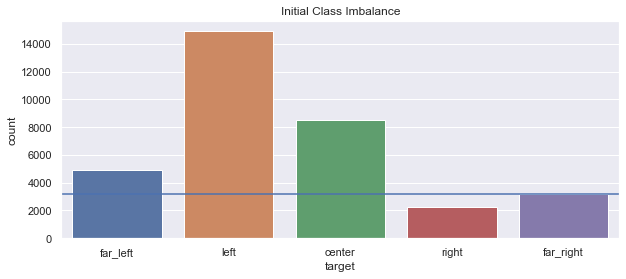

In [46]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x='target', data=data)
ax.axhline(3179)
ax.set_title('Initial Class Imbalance')
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/class_imbalance.png')


# Test Dummy

In [47]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
X = data['predictor']
y = data['target']

dummy_cf = DummyClassifier(strategy='stratified')
dummy_cf.fit(X,y)
y_preds = dummy_cf.predict(X)

accuracy = dummy_cf.score(X,y)


In [48]:
results = pd.DataFrame(columns = ['model','accuracy'])
new_row = {'model': 'Dummy', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961


# Resample

In [49]:
from sklearn.utils import resample
far_right = data[data.target == 'far_right'] #resample target
right = data[data.target == 'right'] #upsample
center = data[data.target == 'center'] #downsample
left = data[data.target =='left'] #downsample
far_left = data[data.target == 'far_left'] #downsample

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

center_downsampled = resample(center,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

left_downsampled = resample(left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

far_left_downsampled = resample(far_left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

data = pd.concat([far_right, right_upsampled, center_downsampled,left_downsampled,far_left_downsampled])
data.target.value_counts()

left         3179
right        3179
center       3179
far_right    3179
far_left     3179
Name: target, dtype: int64

In [50]:
data.reset_index(drop=True,inplace=True)

# Topic Modeling with LDA

In [51]:
import gensim

In [52]:
lda_far_right = data[data['target']=='far_right']['predictor']
lda_right = data[data['target']=='right']['predictor']
lda_center = data[data['target']=='right']['predictor']
lda_left = data[data['target']=='right']['predictor']
lda_far_left = data[data['target']=='far_left']['predictor']
all_sides = data['predictor']

In [42]:
lda_far_right_token = lda_far_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_far_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_far_right_token]

far_right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

far_right_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:20<00:00, 156.86it/s]


[(0,
  '0.014*"coronavirus" + 0.010*"china" + 0.006*"chinese" + 0.006*"state" + 0.005*"percent" + 0.005*"government" + 0.005*"report" + 0.005*"people" + 0.004*"would" + 0.004*"pandemic"'),
 (1,
  '0.013*"trump" + 0.011*"coronavirus" + 0.010*"president" + 0.008*"people" + 0.006*"biden" + 0.005*"time" + 0.005*"would" + 0.005*"make" + 0.004*"know" + 0.004*"pandemic"'),
 (2,
  '0.015*"coronavirus" + 0.011*"state" + 0.009*"test" + 0.007*"case" + 0.006*"people" + 0.006*"report" + 0.006*"health" + 0.005*"virus" + 0.005*"covid" + 0.004*"trump"')]

Topic 1: Trump, Corona, Police

Topic 2: Coronavirus and China

Topic 3: Coronavirus and Masks

In [43]:
lda_right_token = lda_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_right_token]

right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

right_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:21<00:00, 145.12it/s]


[(0,
  '0.014*"coronavirus" + 0.009*"covid" + 0.008*"trump" + 0.007*"virus" + 0.006*"president" + 0.006*"news" + 0.005*"people" + 0.005*"study" + 0.005*"health" + 0.004*"report"'),
 (1,
  '0.011*"coronavirus" + 0.006*"people" + 0.005*"time" + 0.004*"state" + 0.004*"news" + 0.004*"pandemic" + 0.004*"would" + 0.004*"also" + 0.004*"vote" + 0.003*"like"'),
 (2,
  '0.016*"coronavirus" + 0.009*"trump" + 0.009*"state" + 0.007*"people" + 0.007*"news" + 0.007*"test" + 0.006*"case" + 0.006*"health" + 0.006*"covid" + 0.006*"report"')]

Topic 1: Covid testing/reporting

Topic 2: Coronavirus and opening schools

Topic 3: Trump, Biden, and Covid responses

In [44]:
lda_center_token = lda_center.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_center_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_center_token]

center_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

center_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:17<00:00, 182.49it/s]


[(0,
  '0.021*"coronavirus" + 0.011*"covid" + 0.009*"case" + 0.009*"report" + 0.008*"health" + 0.008*"virus" + 0.007*"test" + 0.007*"state" + 0.007*"news" + 0.006*"study"'),
 (1,
  '0.009*"coronavirus" + 0.006*"state" + 0.006*"people" + 0.004*"time" + 0.004*"would" + 0.004*"pandemic" + 0.004*"make" + 0.004*"trump" + 0.004*"news" + 0.003*"even"'),
 (2,
  '0.017*"trump" + 0.014*"coronavirus" + 0.011*"president" + 0.007*"test" + 0.007*"biden" + 0.007*"news" + 0.007*"people" + 0.006*"state" + 0.005*"covid" + 0.005*"time"')]

Topic 1: Trumps and China coronavirus

Topic 2: Covid Testing

Topic 3: Covid and School

In [45]:
lda_left_token = lda_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_left_token]

left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

left_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:17<00:00, 179.57it/s]


[(0,
  '0.014*"trump" + 0.012*"coronavirus" + 0.010*"president" + 0.007*"people" + 0.006*"biden" + 0.006*"news" + 0.006*"state" + 0.005*"test" + 0.005*"time" + 0.005*"covid"'),
 (1,
  '0.018*"coronavirus" + 0.009*"case" + 0.008*"covid" + 0.007*"health" + 0.007*"report" + 0.007*"virus" + 0.007*"people" + 0.006*"state" + 0.006*"test" + 0.006*"news"'),
 (2,
  '0.013*"coronavirus" + 0.006*"state" + 0.006*"covid" + 0.005*"news" + 0.004*"time" + 0.004*"trump" + 0.004*"health" + 0.004*"would" + 0.004*"house" + 0.004*"also"')]

Topic 1: Covid testing

Topic 2: Coronavirus research and vaccines

Topic 3: Covid cases under trump

In [46]:
lda_far_left_token = lda_far_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_far_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_far_left_token]

far_left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

far_left_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:53<00:00, 58.43it/s]


[(0,
  '0.006*"make" + 0.005*"coronavirus" + 0.005*"like" + 0.005*"time" + 0.004*"people" + 0.004*"twitter" + 0.004*"also" + 0.003*"mask" + 0.003*"work" + 0.003*"pandemic"'),
 (1,
  '0.010*"people" + 0.007*"coronavirus" + 0.006*"like" + 0.006*"time" + 0.006*"work" + 0.005*"also" + 0.005*"make" + 0.004*"take" + 0.004*"pandemic" + 0.004*"company"'),
 (2,
  '0.013*"trump" + 0.009*"coronavirus" + 0.008*"state" + 0.007*"people" + 0.005*"president" + 0.005*"covid" + 0.005*"would" + 0.004*"health" + 0.004*"case" + 0.004*"time"')]

Topic 1: Working in Covid

Topic 2: Trump and Coronavirus

Topic 3:Working in Covid

In [53]:
all_token = all_sides.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(all_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in all_token]

all_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

all_lda.show_topics(formatted=True)

100%|██████████| 15895/15895 [01:29<00:00, 177.01it/s]


[(0,
  '0.010*"coronavirus" + 0.007*"border" + 0.006*"travel" + 0.005*"release" + 0.004*"flight" + 0.004*"report" + 0.004*"news" + 0.004*"immigration" + 0.004*"people" + 0.004*"mexico"'),
 (1,
  '0.011*"coronavirus" + 0.009*"game" + 0.008*"test" + 0.007*"play" + 0.007*"season" + 0.006*"league" + 0.006*"team" + 0.006*"positive" + 0.006*"players" + 0.005*"time"'),
 (2,
  '0.016*"coronavirus" + 0.011*"covid" + 0.010*"test" + 0.009*"people" + 0.008*"health" + 0.007*"virus" + 0.007*"patients" + 0.007*"mask" + 0.006*"also" + 0.005*"study"'),
 (3,
  '0.008*"people" + 0.007*"time" + 0.007*"like" + 0.007*"make" + 0.006*"work" + 0.006*"pandemic" + 0.004*"even" + 0.004*"many" + 0.004*"workers" + 0.004*"also"'),
 (4,
  '0.015*"coronavirus" + 0.013*"vaccine" + 0.007*"would" + 0.006*"bill" + 0.006*"million" + 0.006*"house" + 0.005*"fund" + 0.005*"covid" + 0.005*"billion" + 0.005*"relief"'),
 (5,
  '0.017*"coronavirus" + 0.017*"case" + 0.017*"state" + 0.011*"people" + 0.009*"health" + 0.009*"report" 

Topic 1: COVID, Immigration, Travel

Topic 2: COVID and Sports

Topic 3: COVID Testing Results

Topic 4: COVID and Working

Topic 5: COVID, Legislation and Vaccines

Topic 6: COVID Cases Increasing

Topic 7: COVID and China

Topic 8: COVID and Election

In [54]:
dominant_topics = []

for i in data.index:
    row_list = all_lda[bow_corpus][i]
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic = row[0][0]
    dominant_topics.append(topic)
    

In [55]:
data['dominant_topic'] = pd.Series(dominant_topics)

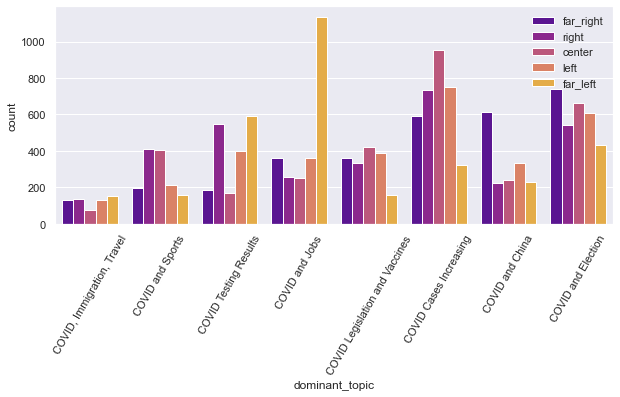

In [56]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x='dominant_topic', hue='target',data=data,palette='plasma')
ax.set_xticklabels(['COVID, Immigration, Travel',
                    'COVID and Sports',
                   'COVID Testing Results',
                   'COVID and Jobs',
                   'COVID Legislation and Vaccines',
                   'COVID Cases Increasing',
                   'COVID and China',
                   'COVID and Election'])

ax.legend(loc='upper right', frameon=False)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/topic_by_target.png')

plt.show()

In [57]:
data.to_csv('clean_data2.csv')

# EDA

In [58]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 28s, sys: 489 ms, total: 1min 28s
Wall time: 1min 29s


TfidfVectorizer(preprocessor=<function clean_txt at 0x10afd5ee0>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [59]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['far_left','left','center','right','far_right']:
    print("Top 20 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(20)
    print(df_right)
    print("###############")
    if cat != 'far_left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 20 terms for:  far_left
          Terms   far_left
0        people  73.528729
1   coronavirus  69.019919
2          like  68.412943
3          time  64.470003
4          make  64.431703
5         trump  63.969943
6          also  56.370440
7          even  54.101620
8      pandemic  54.067740
9          take  53.044862
10         work  52.735271
11        covid  52.622918
12        would  52.465999
13         home  49.983792
14         tell  48.644786
15         many  46.709777
16         want  46.390417
17      company  45.611710
18        state  45.257805
19         call  44.773750
###############
(20, 2)
Top 20 terms for:  left
          Terms       left
0   coronavirus  89.672582
1         trump  77.987280
2        people  76.210783
3         state  71.887449
4          test  70.975466
5         covid  70.964780
6          case  70.818901
7        health  70.017666
8         virus  64.747240
9     president  62.794284
10     pandemic  60.555966
11         also  60.511051
12    

In [65]:
df_top20_words

,far_left,left,center,right,far_right
Terms,,,,,
people,73.528729,76.210783,65.310597,68.730208,67.225541
coronavirus,69.019919,89.672582,96.027165,104.310221,98.472754
like,68.412943,0.000000,0.000000,0.000000,0.000000
time,64.470003,54.728938,0.000000,57.877421,52.694302
make,64.431703,51.786893,0.000000,0.000000,0.000000
trump,63.969943,77.987280,79.127369,69.672496,91.214350
also,56.370440,60.511051,50.147055,55.850944,0.000000
even,54.101620,0.000000,0.000000,0.000000,0.000000
pandemic,54.067740,60.555966,60.528445,55.837622,52.835021


In [64]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

KeyError: "None of ['Terms'] are in the columns"

In [66]:
import numpy as np
from textacy.viz.termite import draw_termite_plot

In [67]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

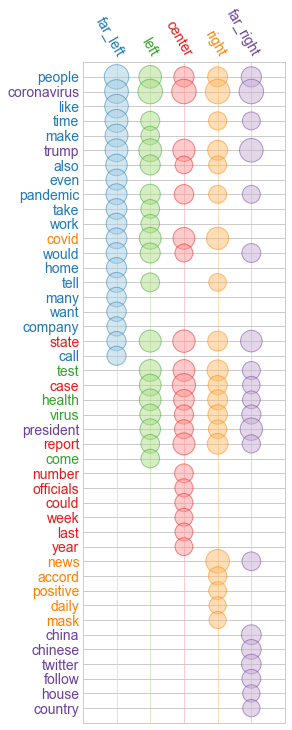

In [68]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2,3,4])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/termite_plot.png')

**Polarity by target**

In [69]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

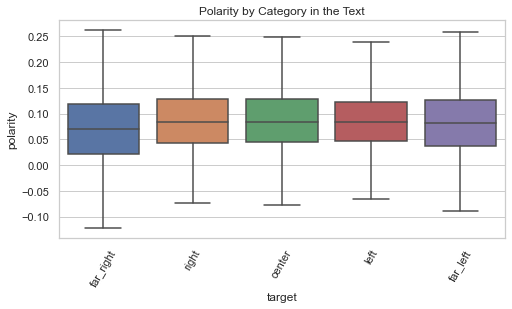

In [74]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Polarity by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_by_target.png')

**Polarity over time**

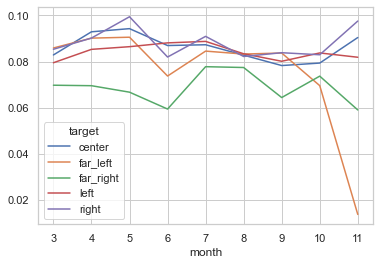

In [81]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_time.png')

**Subjectivity by target**

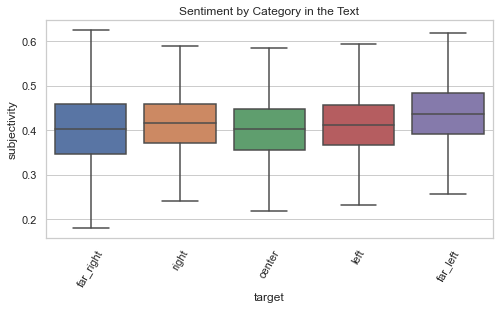

In [82]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_by_target.png')

**Subjectivity over time**

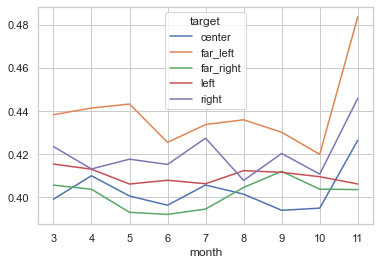

In [83]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_time.png')

**n_long_words by target**

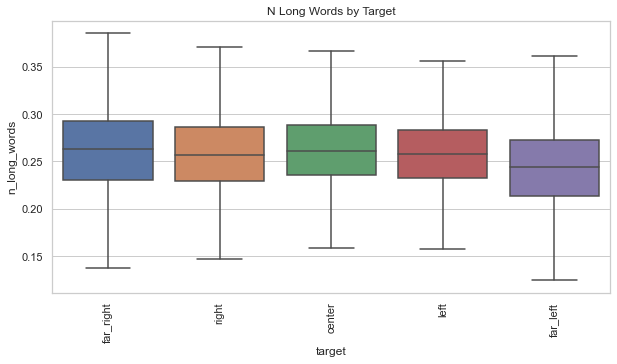

In [84]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Long Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/longwords_target.png')

**n_monosyllable_words by target**

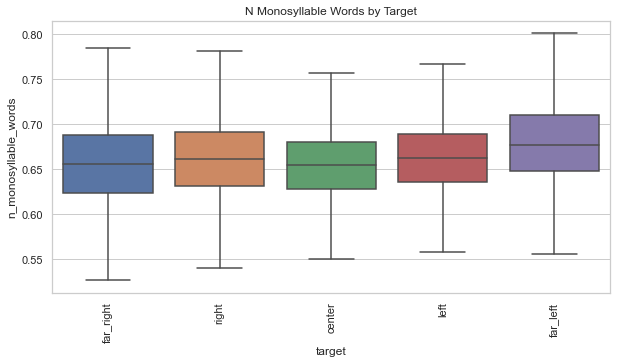

In [85]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Monosyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mono_target.png')

**n_polysyllable_words by target**

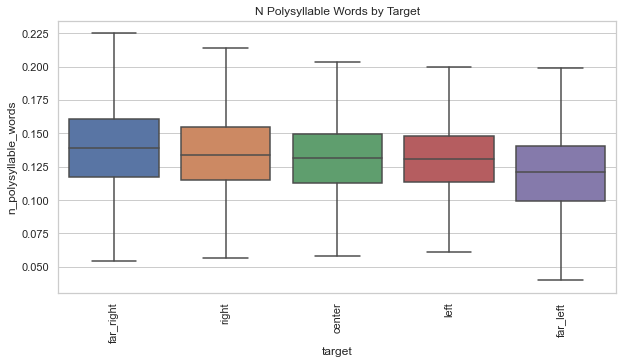

In [86]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Polysyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/poly_target.png')

**n_unique_words by target**

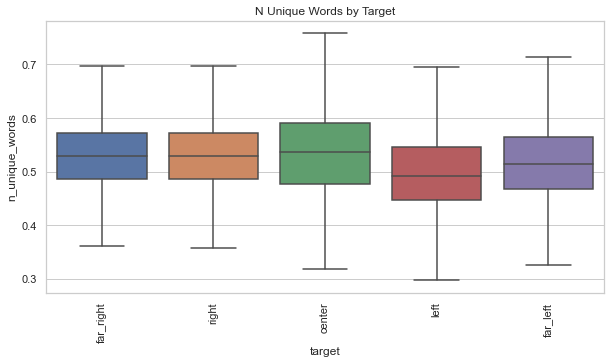

In [90]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Unique Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/unique_target.png')

**mccphw by target**

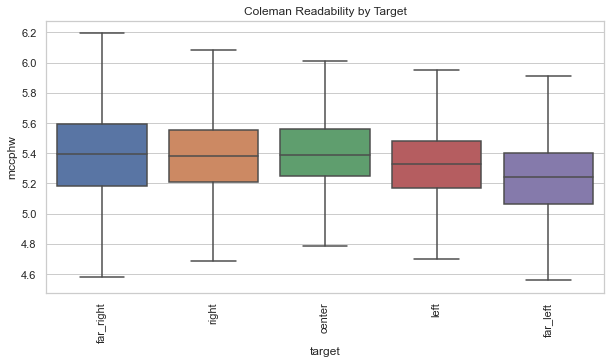

In [91]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="mccphw", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mccphw_target.png')


**coleman_index by target**

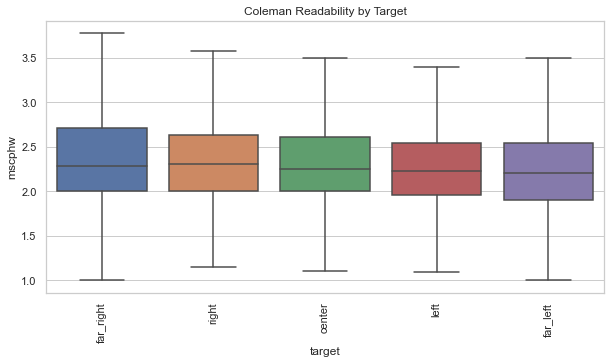

In [92]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="mscphw", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mccphw_target.png')


**coleman_index by target**

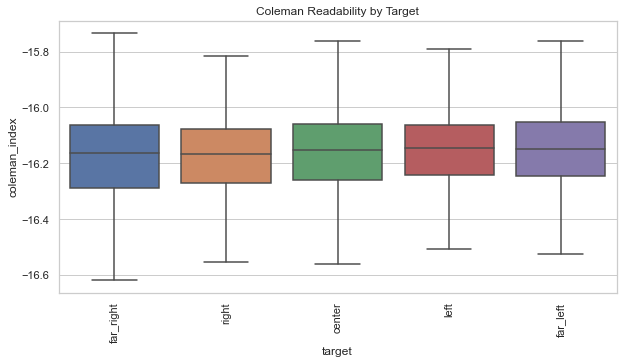

In [89]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="coleman_index", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/coleman_index.png')


**Profanity**

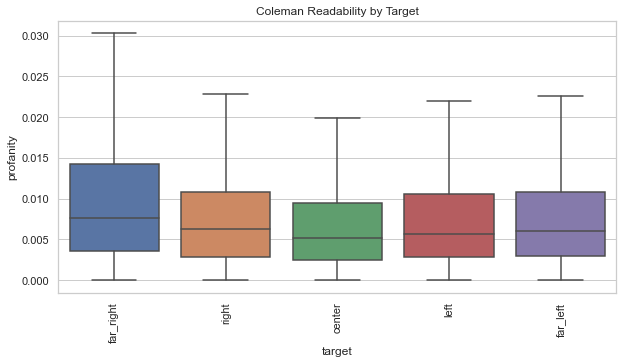

In [95]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="profanity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/coleman_index.png')


In [97]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(train_vec.toarray())